# Driver safety estimation
Pointer Telocation is a developer of telocation devices for cars, focusing on fleet management and MRM (Mobile Resource Management). 
In addition to speed and location, the devices are capable of emitting different events related to driver behavior, such as harsh turns, harsh acceleration and harsh braking.

The objective of this project is to estimate a specific driver's safety score, for various business scenarios. Additional use cases include driver identification, eco-scoring and theft detection by deviation from the routine driver behavior.

## Data understanding and preparation

#### Load packages and set display options for notebook

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt

## Supress scientific notation
pd.options.display.float_format = '{:.4f}'.format

### Exploratory data analysis
The data represents various events created by the in-car devices. Most of the events are system events and some are behavioral driver events.
We will have two different data frames: *dfRaw* will contain all event types, and *df* will contain only events relevant for analysis, such as behavioral events (harsh turns, accelerations etc.)

To read the data from file:

In [3]:
## read data from csv
dfRaw = pd.read_csv("dataset.csv")
dfRaw['ts']= pd.to_datetime(dfRaw.ts)

#### Observe the first rows

In [4]:
dfRaw.iloc[1400:1410,:]

,DriverId,EventName,Latitude,Longitude,Speed km/h,ts
1400,0,Distance Event,34.1918,-118.1112,51.0000,2017-11-02 15:33:06.010
1401,0,Distance Event,34.1921,-118.1122,37.0000,2017-11-02 15:33:14.100
1402,0,Harsh Acceleration,34.1924,-118.1128,52.0000,2017-11-02 15:33:36.500
1403,0,Distance Event,34.1924,-118.1130,60.0000,2017-11-02 15:33:37.650
1404,0,Harsh Acceleration,34.1924,-118.1130,60.0000,2017-11-02 15:33:37.440
1405,0,Harsh Acceleration,34.1923,-118.1131,67.0000,2017-11-02 15:33:38.490
1406,0,Distance Event,34.1924,-118.1130,60.0000,2017-11-02 15:33:37.190
1407,0,Distance Event,34.1920,-118.1140,78.0000,2017-11-02 15:33:42.640
1408,0,Distance Event,34.1914,-118.1150,87.0000,2017-11-02 15:33:47.230
1409,0,Timed Event,34.1914,-118.1150,87.0000,2017-11-02 15:33:48.270


The dataset contains events of various types (behavioral or functional) stored in the *EventName* column, in addition to metadata such as the current location (*Latitude* and *Longitude* columns), *Speed  km/h* and time (*ts* column). *DriverId* is the unique identifier of a driver.

#### Time in which samples were collected

In [5]:
maxTime = dfRaw['ts'].max()
minTime = dfRaw['ts'].min()
print("Events were taken between " + str(minTime.date()) + " and " + str(maxTime.date()))

Events were taken between 2017-10-31 and 2017-11-18


#### Number of cars

In [6]:
driverCount = len(dfRaw.DriverId.value_counts())
print("Number of drivers: {}".format(driverCount))

Number of drivers: 242


#### Number of events per car

In [7]:
eventsPerDriver = dfRaw.groupby('DriverId').agg({"EventName":"count"}).add_suffix('_count')
print("Mean number of events per driver {:0.1f}".format(np.mean(eventsPerDriver).values[0]))
eventsPerDriver.head(10)

Mean number of events per driver 7434.8


,EventName_count
DriverId,
0,17345
1,20694
2,11945
3,819
4,6811
5,24152
6,5700
7,12693
8,19606


#### Events per subscriber - drill down
What is the distribution of events across subscribers?

Text(0,0.5,'Number of drivers')

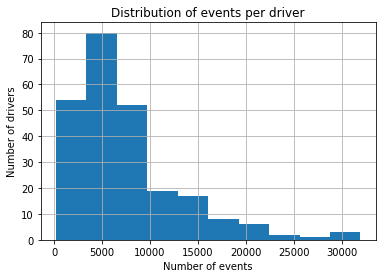

In [8]:
eventsPerDriver.sort_values(by='EventName_count',ascending = False,inplace = True)

eventsHist = eventsPerDriver['EventName_count'].hist()
eventsHist.set_title("Distribution of events per driver")
eventsHist.set_xlabel("Number of events")
eventsHist.set_ylabel("Number of drivers")

#### Events type
What kind of events are there? does looking at specific events change the distribution per driver?

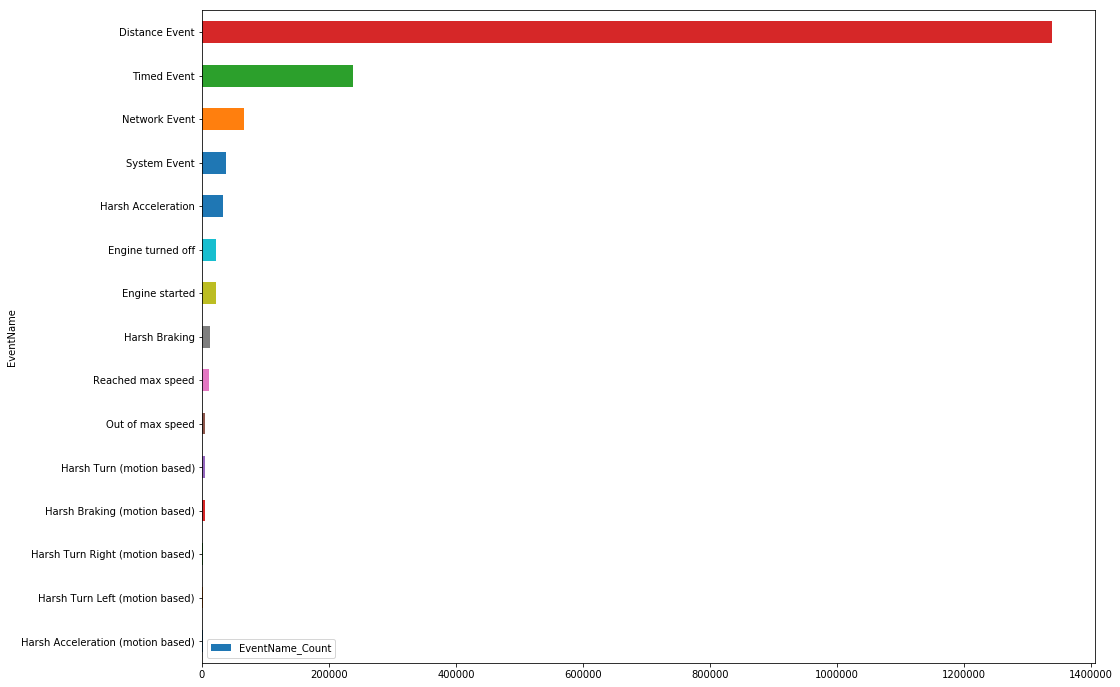

In [9]:
dfReasonHist = dfRaw.groupby(['EventName'])[['EventName']].agg('count').add_suffix('_Count').reset_index().sort_values('EventName_Count',ascending=True)
dfReasonHist.plot.barh('EventName','EventName_Count',figsize=(16,12),)

Removing the Distance, Timed and Network events results in much less events:

In [10]:
events = [event for event in dfRaw.EventName if event not in ['Distance Event','Timed Event','Network Event','System Event']]
newCount = len(dfRaw[dfRaw['EventName'].isin(events)])
print("# of events before removing Distance Event, Timed Event, Network Event: {}, After removing: {}.\nReduction of {:0.2f} events.".format(len(dfRaw),newCount,(len(dfRaw) - newCount)/len(dfRaw)))

# of events before removing Distance Event, Timed Event, Network Event: 1799222, After removing: 119429.
Reduction of 0.93 events.


#### Data prep
Remove non-behavioral events, remove drivers with too few samples and a few more cleanups

In [11]:
RELEVANT_EVENTS = ['Harsh Acceleration', 'Reached max speed', 'Out of max speed',
       'Harsh Braking', 'Harsh Turn (motion based)',
       'Harsh Braking (motion based)', 'Harsh Acceleration (motion based)',
       'Harsh Turn Left (motion based)', 'Harsh Turn Right (motion based)']


def prepData(dfRaw, minRecordsPerSubscriber = 50):
    dfRaw.reset_index(inplace=True)
    print("*** Starting data prep. Length:",len(dfRaw),"***")
  
    
    #Remove NAs
    dfRaw = dfRaw.dropna()
    print("Removed NAs. Length:",len(dfRaw))

    ## Filter out unwanted events
    df = dfRaw[dfRaw.EventName.isin(RELEVANT_EVENTS)]
    print("Keeping only events that are relevant for modeling. Length:",len(df))
    
    
    ## Filter out users with too few samples
    eventCountPerDriver = df.groupby('DriverId')['DriverId'].agg('count')
    driversWithManyRecords = eventCountPerDriver[eventCountPerDriver > minRecordsPerSubscriber]
    driversWithManyRecords.keys()
    df = df[df.DriverId.isin(driversWithManyRecords.keys())]
    print("Filtering users with too few samples. Length:",len(df))

    print("*** Done. ***")
    return(df)

df = prepData(dfRaw)

df.head()

*** Starting data prep. Length: 1799222 ***
Removed NAs. Length: 1799219
Keeping only events that are relevant for modeling. Length: 75654
Filtering users with too few samples. Length: 74730
*** Done. ***


,index,DriverId,EventName,Latitude,Longitude,Speed km/h,ts
41,41,0,Harsh Acceleration,34.1899,-118.0825,49.0000,2017-11-01 14:30:12.120
112,112,0,Reached max speed,34.1809,-118.1381,115.0000,2017-11-01 14:35:26.830
130,130,0,Out of max speed,34.1695,-118.1449,69.0000,2017-11-01 14:36:19.710
149,149,0,Harsh Braking,34.1605,-118.1414,98.0000,2017-11-01 14:38:01.930
186,186,0,Reached max speed,34.1393,-118.1485,122.0000,2017-11-01 14:39:59.440


#### Distribution of events per subscriber, while removing functional (non-behavioral) events

Text(0,0.5,'Number of drivers')

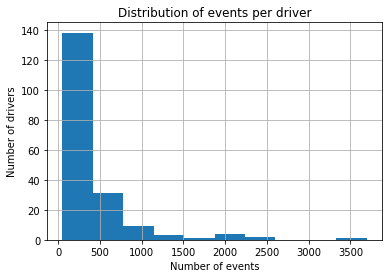

In [12]:
relevantEventsPerSubscriber = df.groupby('DriverId').agg({"EventName":"count"}).sort_values(by='EventName',ascending = False)

eventsHist = relevantEventsPerSubscriber['EventName'].hist()
eventsHist.set_title("Distribution of events per driver")
eventsHist.set_xlabel("Number of events")
eventsHist.set_ylabel("Number of drivers")

Types of events:

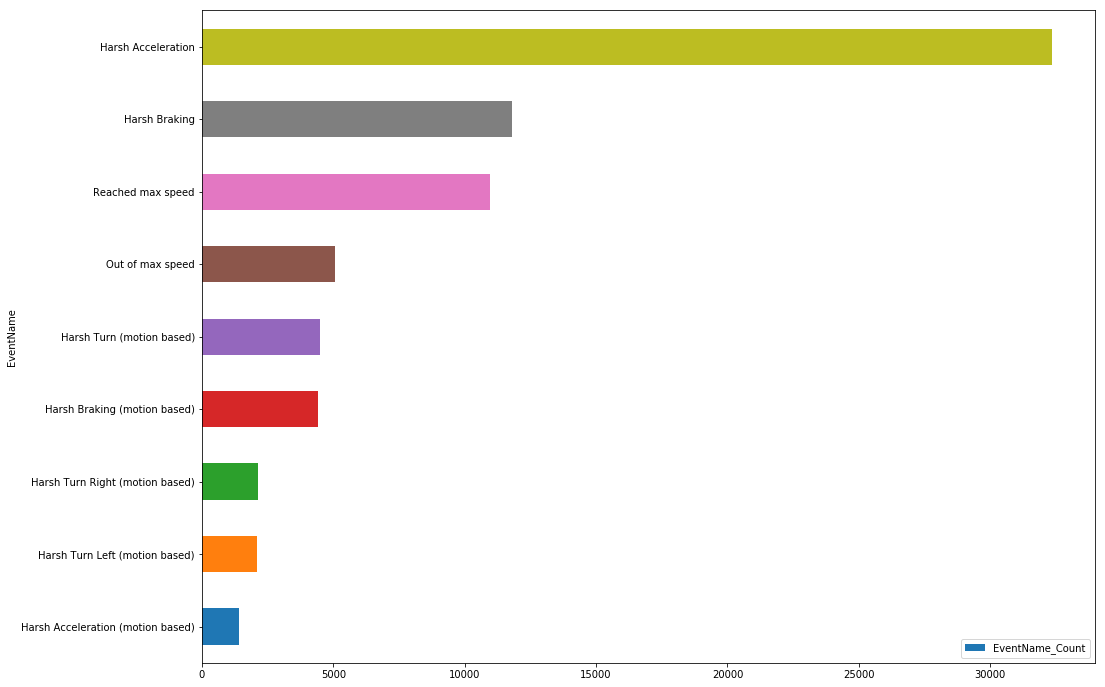

In [13]:
dfReasonHist = df.groupby('EventName')[['EventName']].agg('count').add_suffix('_Count').reset_index().sort_values('EventName_Count',ascending=True)
dfReasonHist.head(30)
dfReasonHist.plot.barh('EventName','EventName_Count',figsize=(16,12))

Some insights from this chart:
1. The number of high speed start events != number of events of end of high speed, which raises a red flag. In addition, the calculation could be inaccurate since it compares the current car speed with a constant (e.g. 120 km/h) and not to the actual speed limit, so we will not be using it. The correct approach is to use an API that provides road segment max speed, and compare the car's speed to the max speed. These APIs also have the option of snap-to-road which eliminated errors due to inaccurate GPS readings. For more info, see here: https://www.microsoft.com/en-us/maps/snap-to-road

2. There are multiple events that represent the same thing. For example, 'Harsh Acceleration' and 'Harsh Acceleration (motion based)'. This is due to different versions of the device, or to different sensors installed on different cars.

3. The motion based device has three values for harsh turning: Harsh Turn, Harsh Turn Left and Harsh Turn Right. We can further see that Harsh Turn Left + Harsh Turn Right != Harsh Turn. This is due to the time in which each event type was introduced into the system. We will use Harsh Turn and ignore the left and right values.

Since some drivers have more days of data on the system than others, looking at the absolute number of events isn't accurate. Instead, we'll normalize the number of events per driver by dividing by either total drive time or total distance.

In this code we calculate the total distance each driver had travelled:

In [14]:
## Calculate haversine distance (https://en.wikipedia.org/wiki/Haversine_formula)
## Code taken (and modified) from here: https://stackoverflow.com/questions/29545704/fast-haversine-approximation-python-pandas
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

def total_distance(oneDriver):
    dist = haversine(oneDriver.Longitude.shift(1), oneDriver.Latitude.shift(1),
                 oneDriver.loc[1:, 'Longitude'], oneDriver.loc[1:, 'Latitude'])
    return np.sum(dist)


## Calculate the overall distance made by each driver
def calculate_overall_distance_travelled(dfRaw):
    dfDistancePerDriver = dfRaw.groupby('DriverId').apply(total_distance).reset_index(name='Distance')    
    return dfDistancePerDriver

distancePerDriver = calculate_overall_distance_travelled(dfRaw)
distancePerDriver.head(30)

,DriverId,Distance
0,0,1753.2018
1,1,1918.8171
2,2,1074.2893
3,3,391.8667
4,4,534.5035
5,5,2273.0337
6,6,586.1509
7,7,1125.1642
8,8,1849.9005
9,9,426.7735


## Feature engineering
We define a feature set as the normalized number of events per type. For each behavioral event, we count the number of events and divide by total drive distance. For over-speeding, one can calculate the total amount of time each driver was over speeding, or some metric for the ratio between the current speed and the allowed maximum speed.

In [15]:
## Transform the events data frame to a features data frame (column for each type of relevant event)
def create_feature_set(df, distancePerDriver):
    dfEventAggByDriver = df.groupby(['DriverId','EventName'])[['EventName']].agg('count').add_suffix('_Count').reset_index()

    
    ## Pivot events into columns
    dfEventMatrix = dfEventAggByDriver.pivot(index='DriverId',columns='EventName', values='EventName_Count').add_prefix('F_').fillna(0).reset_index()
    dfEventMatrix = dfEventMatrix.merge(distancePerDriver, how = 'inner',on='DriverId')
    dfEventMatrix.set_index('DriverId', inplace=True)
    
    featureCols = [col for col in dfEventMatrix if col.startswith('F_')]
    dfEventMatrix[featureCols] = dfEventMatrix[featureCols].div(dfEventMatrix['Distance'], axis=0)

    dfFeatureSet = dfEventMatrix[featureCols]
    
    return dfFeatureSet

features = create_feature_set(df,distancePerDriver)

In [16]:
features.head()

,F_Harsh Acceleration,F_Harsh Acceleration (motion based),F_Harsh Braking,F_Harsh Braking (motion based),F_Harsh Turn (motion based),F_Harsh Turn Left (motion based),F_Harsh Turn Right (motion based),F_Out of max speed,F_Reached max speed
DriverId,,,,,,,,,
0,0.1603,0.0006,0.0496,0.0262,0.0148,0.0143,0.0086,0.0251,0.0331
1,0.0547,0.0005,0.0229,0.0047,0.0000,0.0057,0.0042,0.0344,0.0391
2,0.1797,0.0102,0.0642,0.0279,0.0121,0.0028,0.0000,0.0140,0.0242
4,0.1235,0.0000,0.1553,0.0543,0.0973,0.0692,0.0206,0.0262,0.0243
5,0.1403,0.0026,0.0330,0.0110,0.0396,0.0079,0.0207,0.0268,0.0458


Since there are two types of systems (motion based and not), we will look at one at a time and not join the two as the values and their proportions might be incomparable. In addition, we'll ignore the inaccurate over speeding event, as noted earlier. 

In [17]:
features = features[['F_Harsh Acceleration (motion based)','F_Harsh Braking (motion based)','F_Harsh Turn (motion based)']]
features.head()

,F_Harsh Acceleration (motion based),F_Harsh Braking (motion based),F_Harsh Turn (motion based)
DriverId,,,
0,0.0006,0.0262,0.0148
1,0.0005,0.0047,0.0000
2,0.0102,0.0279,0.0121
4,0.0000,0.0543,0.0973
5,0.0026,0.0110,0.0396


### Scatterplot matrix of features

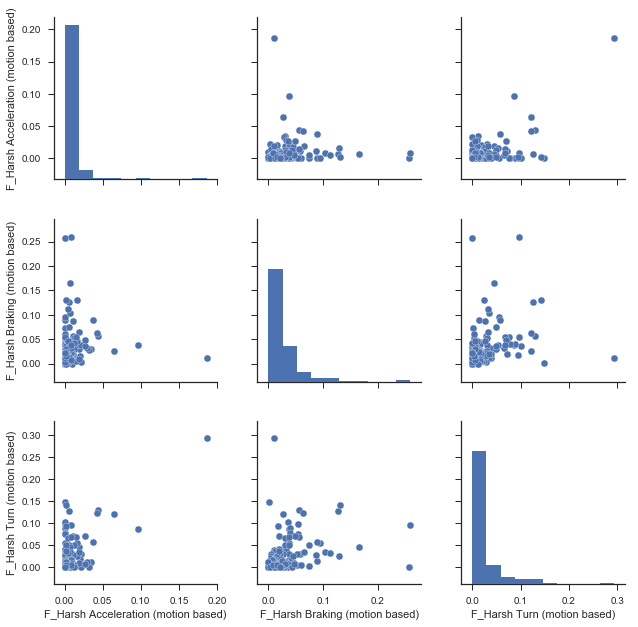

In [18]:
import seaborn as sns
sns.set(style="ticks")
sns.pairplot(features, size=3)

All features are skewed to the right with a long tail.

#### Example of a car with many events of one type

In [19]:
features.loc[features['F_Harsh Turn (motion based)'].idxmax(), ]

F_Harsh Acceleration (motion based)   0.1864
F_Harsh Braking (motion based)        0.0107
F_Harsh Turn (motion based)           0.2937
Name: 51, dtype: float64

### Outliers handling
We wish to remove/adjust outliers as they affect many statistical approaches. In order to remove these, we'll transform the features to normal (using a box-cox transformation) and remove based on *mean + k*std's* rule. A second approach could be to truncate the tail using some constant, but it will be more difficult to find this threshold than the standard deviation rule. A third option is to remove outliers on all three dimensions (using a multivariate normal distribution, for example).

This code performs the first option, box-cox transformation:

In [20]:
import scipy.stats as st

def transform_to_normal(x):
    xt = np.zeros(len(x))
    if np.count_nonzero(x) == 0:
        print("only zero valued values found")
        return x
    
    valueGreaterThanZero = np.where(x<=0,0,1)
    positives = x[valueGreaterThanZero == 1]
    if(len(positives)> 0):
        xt[valueGreaterThanZero == 1],_ = st.boxcox(positives+1)
    xt = xt - np.min(xt)
    return xt

transFeatures = features.apply(lambda x: (transform_to_normal(x)))
transFeatures.head()

,F_Harsh Acceleration (motion based),F_Harsh Braking (motion based),F_Harsh Turn (motion based)
DriverId,,,
0,0.0006,0.0183,0.0118
1,0.0005,0.0044,0.0000
2,0.0072,0.0191,0.0100
4,0.0000,0.0273,0.0298
5,0.0024,0.0094,0.0223


### Scatter plot matrix of transformed features

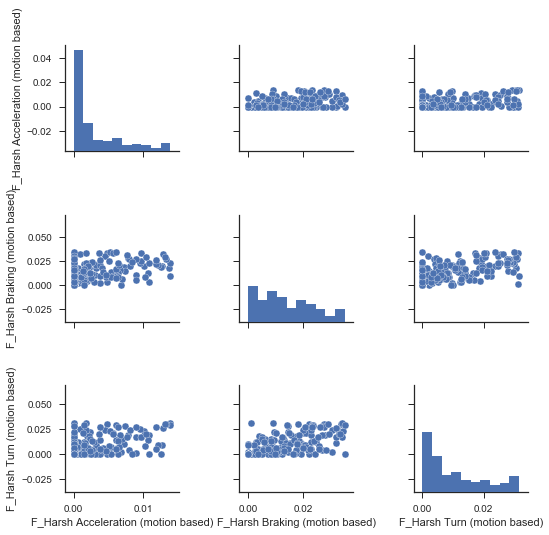

In [21]:
sns.pairplot(transFeatures)

You can see that the distribution is not symmetric yet, but not as skewed as the original data.
Let's use the mean + k std rule:

In [22]:
### remove outliers
import seaborn as sns
sns.set(style="ticks")

def replace_outliers_with_limit(x, stdFactor = 2.5):
    print(x.name)
    x = x.values
    xt = np.zeros(len(x))
    if np.count_nonzero(x) == 0:
        print("only zero valued values found")
        return x
    
    xt = transform_to_normal(x)
    
    xMean, xStd = np.mean(xt), np.std(xt)
    outliers = np.where(xt > xMean + stdFactor*xStd)[0]
    inliers = np.where(xt <= xMean + stdFactor*xStd)[0]
    if len(outliers) > 0:
        print("found outlier with factor: "+str(stdFactor)+" : "+str(outliers))
        xinline = x[inliers]
        maxInRange = np.max(xinline)
        print("replacing outliers {} with max={}".format(outliers,maxInRange))
        vals = x.copy()
        vals[outliers] = maxInRange
        x= pd.Series(vals)
    else:
        print("No outliers found")
    return x

cleanFeatures = features.apply(lambda x: (replace_outliers_with_limit(x)))
cleanFeatures.head(6)


F_Harsh Acceleration (motion based)
found outlier with factor: 2.5 : [ 15  44  78  82  89 113 163]
replacing outliers [ 15  44  78  82  89 113 163] with max=0.03250754234955105
F_Harsh Acceleration (motion based)
found outlier with factor: 2.5 : [ 15  44  78  82  89 113 163]
replacing outliers [ 15  44  78  82  89 113 163] with max=0.03250754234955105
F_Harsh Braking (motion based)
No outliers found
F_Harsh Turn (motion based)
No outliers found


,F_Harsh Acceleration (motion based),F_Harsh Braking (motion based),F_Harsh Turn (motion based)
0,0.0006,0.0262,0.0148
1,0.0005,0.0047,0.0000
2,0.0102,0.0279,0.0121
3,0.0000,0.0543,0.0973
4,0.0026,0.0110,0.0396
5,0.0017,0.0307,0.0358


Outliers found only on the harsh acceleration column

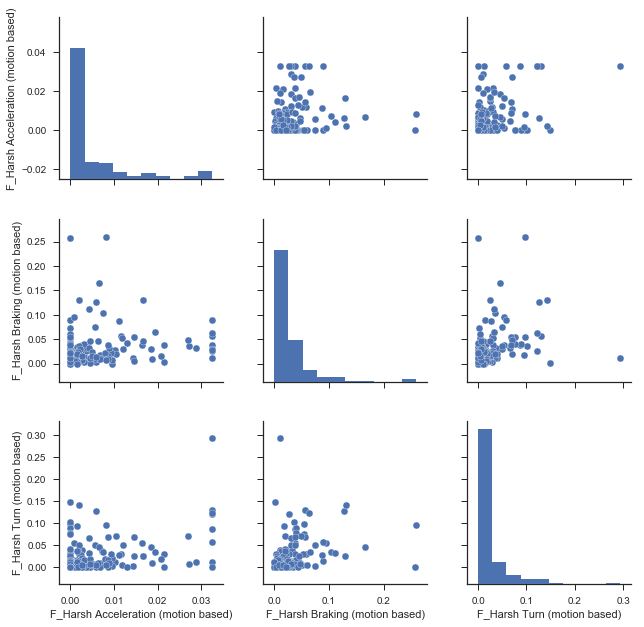

In [23]:
sns.pairplot(cleanFeatures,size = 3)

## Correlations between events

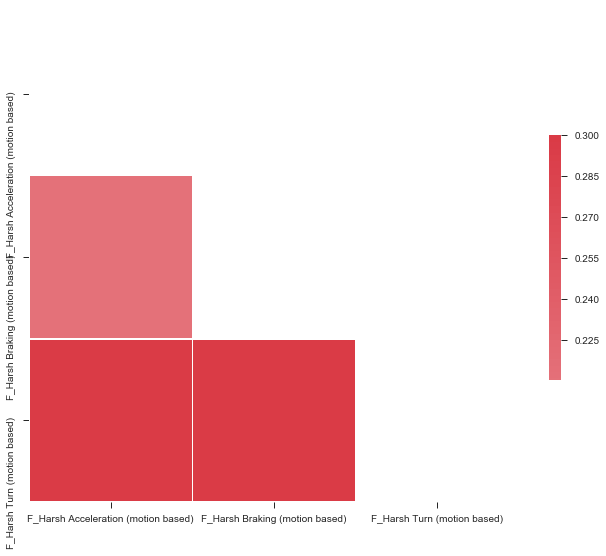

In [24]:
corr = cleanFeatures.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
fig = plt.figure()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Modeling

### Main hypothesis

Our main assumption while analyzing this data, is that the more events a driver has, the more likely her/she is to be unsafe. A driver with zero harsh turns, zero harsh accelerations, zero over speeding and zero harsh braking over some distance, is likely to be a safe driver. On the contrary, making multiple harsh actions over the same distance might indicate that the driver doesn't driver in a safe manner.
### Modeling approaches

There are a few approaches for modeling:
1.	Model the problem as an anomality detection problem, or some sort of clustering to find clusters of safe/unsafe drivers. 
2.	Find a multivariate metric that encompasses our assumption in multi dimensions and allows us to estimate unsafe driving using probabilities over this multivariate distribution.
3.	Reduce the dimension to 1 and try to find a rule/rank on this one unified metric. 
4.	Use a univariate statistical model: Model each event type individually by using statistical distributions.

In the following section we will evaluate some approaches for modeling this data, but first we'll normalize the data:

In [25]:
## Pre step: Normalize features
minPerFeature = cleanFeatures.min()
maxPerFeature = cleanFeatures.max()

print("Min and Max values per column before normalization")
for col in range(0,len(cleanFeatures.columns)):
    print("{} range:[{},{}]".format(cleanFeatures.columns[col],minPerFeature[col],maxPerFeature[col]))

normalizedFeatures = (cleanFeatures-cleanFeatures.min())/(cleanFeatures.max()-cleanFeatures.min())
normalizedFeatures.head()


## Standardize features after box-cox as well.
transFeaturesScaled = (transFeatures - transFeatures.mean())/transFeatures.std()
print("")
print("Mean and STD before standardization")
for col in range(0,len(transFeatures.columns)):
    print("{} range:[{},{}]".format(transFeatures.columns[col],transFeatures.mean()[col],transFeatures.std()[col]))


normalizedFeatures.head()

Min and Max values per column before normalization
F_Harsh Acceleration (motion based) range:[0.0,0.03250754234955105]
F_Harsh Braking (motion based) range:[0.0,0.2595004086534216]
F_Harsh Turn (motion based) range:[0.0,0.29369960316369603]

Mean and STD before standardization
F_Harsh Acceleration (motion based) range:[0.0029187585012747036,0.0038903965176461715]
F_Harsh Braking (motion based) range:[0.013571085212110446,0.009802807623400347]
F_Harsh Turn (motion based) range:[0.010051131098318858,0.009782235199732854]


,F_Harsh Acceleration (motion based),F_Harsh Braking (motion based),F_Harsh Turn (motion based)
0,0.0175,0.1011,0.0505
1,0.0160,0.0181,0.0000
2,0.3150,0.1076,0.0412
3,0.0000,0.2091,0.3312
4,0.0812,0.0424,0.1348


## Anomaly detection: LOF (Local Outlier Filter)
The first approach is anomaly detection. We tried to see if we get meaningful anomalies that might contain information about driver safety.

In [26]:
## LOF - Local Outlier Filter
from sklearn.neighbors import LocalOutlierFactor

X = transFeaturesScaled.values

clf = LocalOutlierFactor(n_neighbors=20)
isOutlier = clf.fit_predict(X)

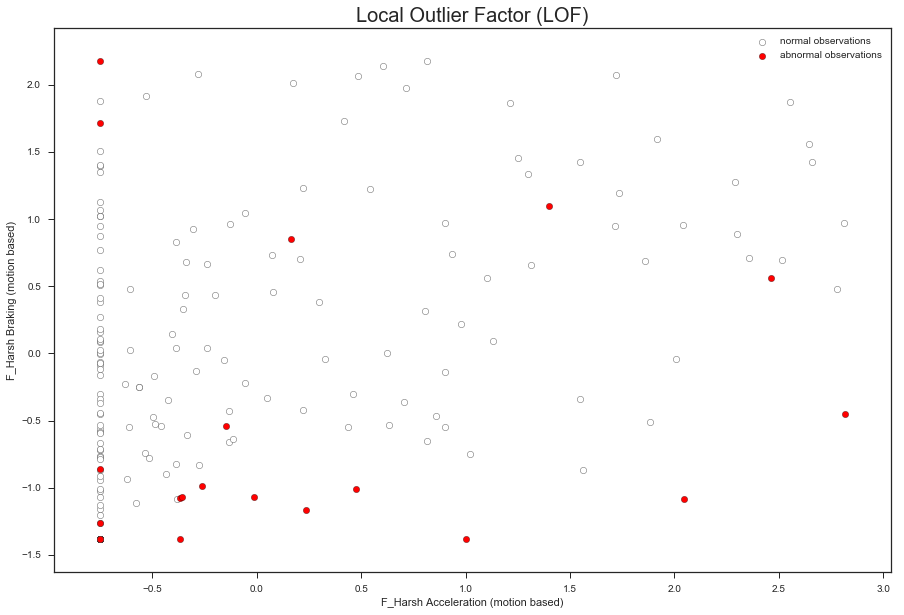

In [27]:
plt.title("Local Outlier Factor (LOF)",fontsize=20)


a = plt.scatter(X[isOutlier==1, 0], X[isOutlier==1, 1], c='white',
                edgecolor='k', s=40)
b = plt.scatter(X[isOutlier==-1, 0], X[isOutlier==-1, 1], c='red',
                edgecolor='k', s=40)
fig = plt.gcf()
fig.set_size_inches(15,10)
plt.xlabel(normalizedFeatures.columns[0])
plt.ylabel(normalizedFeatures.columns[1])
#plt.xlim((-0.01,1.01))
#plt.ylim((-0.01, 1.01))
plt.legend([a, b],
           ["normal observations",
            "abnormal observations"],
           loc="upper right",prop={'size': 10})
plt.show()

This plot shows the found anomalies on the first two dimensions. Even after playing with the model's parameter (number of neighbors), we don't get meaningful results. Looks like statistical outliers don't imply behavioral outliers.

The second approach is to find a multivariate representation of the distribution, in order to calculate the probability of being unsafe vs. the population. We looked at some approaches here but couldn't find a method that would fit this data completely. Many approaches assume normal distribution, have other unmet assumptions, or don't have a robust implementation in python.

The third approach is to try to reduce the dimensionality from 3 or 4 dimensions to 1. We do that not because we have too many dimensions, but as a way to find a compact representation of driver behavior. We could use plenty of tools here. In this case we tried PCA.

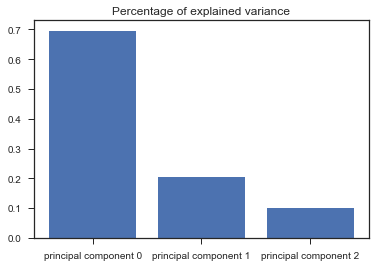

Pricipal components explained variance ratio: [0.69584009 0.203254   0.10090591].


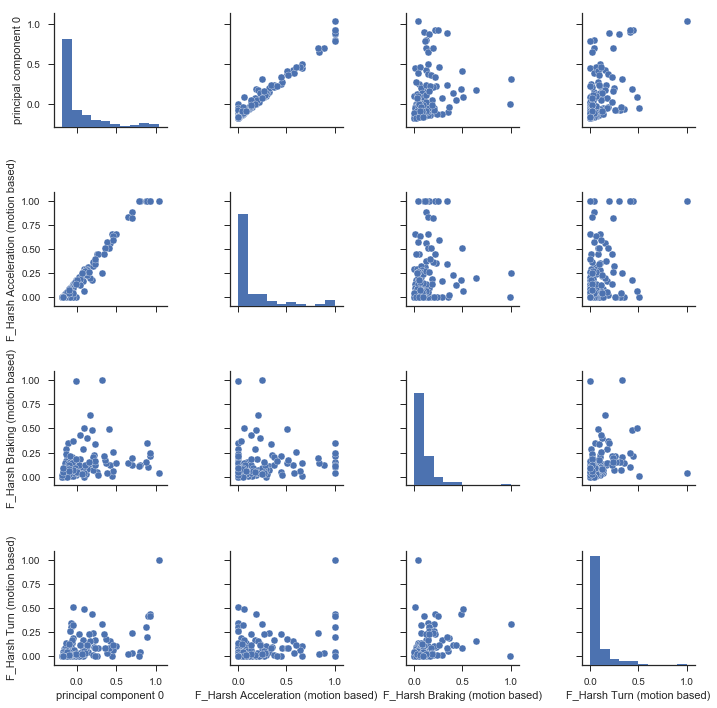

In [28]:
### PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=3)

principalComponents = pca.fit_transform(normalizedFeatures)
column_names = ['principal component {}'.format(i) for i in range(normalizedFeatures.shape[1])]


plt.bar(x = column_names,height = pca.explained_variance_ratio_)
plt.title("Percentage of explained variance")
plt.show()

print("Pricipal components explained variance ratio: {}.".format(pca.explained_variance_ratio_))


principalDf = pd.DataFrame(data = principalComponents
             , columns = column_names)

import matplotlib.pyplot as plt
df = normalizedFeatures
fig = plt.gcf()
fig.set_size_inches(15,10)


## Show correlation matrix of the original features and the first principal component
pcAndOriginal = pd.concat([principalDf.iloc[:,0].reset_index(drop=True), normalizedFeatures], axis=1)
sns.pairplot(pcAndOriginal)


The first principal component is the only one that preserves the order of the data (has positive correlation with all original features). However, since it explains only 69.6% of the variance, it isn't accurate enough for ranking.

The last modeling option is modeling the distribution of each event, in order to evaluate each car by comparing it to a homogenous population. Since all events have a skewed distribution, we will use an exponential/gamma like distribution. 

## Estimation of risk vs. population
In this approach, instead of using a multivariate model that might be difficult to explain, we use a weighted sum of probabilities. For each event type, we estimate the comulative distribution function value (CDF) \begin{equation*}P(X <=x)\end{equation*} and sum over all event types.

It is possible to evaluate goodness-of-fit or the SSE measure between the data and the distribution, in order to detect drifts or changes in the data once it's deployed to production.

#### Extract statistics from the fitted distributions

In [29]:
import scipy.stats as st


def fit_distribution_params(series):
    print("Extracting distribution parameters for feature: " + series.name + " (" + str(len(series)) + ' values)')
    xPositive = series[series>0]
  
    probs = np.zeros(len(series))
    if(len(xPositive)>0):
        params = st.expon.fit(xPositive)
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]
        #print('params = {}, {}, {}.'.format(arg,loc,scale))
        return arg, loc, scale

def calculate_score_for_series(x, fittedParams):
    
    print("Calculating scores for feature: "+ x.name)
    
    xPositive = x[x>0]
  
    probs = np.zeros(len(x))
    if(len(xPositive)>0):
        arg = fittedParams[x.name]['arg']
        loc = fittedParams[x.name]['loc']
        scale = fittedParams[x.name]['scale']
        probs[x>0] = st.expon.cdf(xPositive, loc=loc, scale=scale, *arg)
    return probs


fittedParams = {}
for col in cleanFeatures.columns:
    arg,loc,scale = fit_distribution_params(cleanFeatures[col])
    fittedParams[col] = {}
    fittedParams[col]['arg'] = arg
    fittedParams[col]['loc'] = loc
    fittedParams[col]['scale'] = scale
import json
print('Fitted parameters:')
print(json.dumps(fittedParams, indent=2))

##Commulative distribution/density function
perFeatureScores = cleanFeatures.apply(calculate_score_for_series,args=(fittedParams,),axis=0).add_suffix("_CDF")

perFeatureScores.head()

Extracting distribution parameters for feature: F_Harsh Acceleration (motion based) (189 values)
Extracting distribution parameters for feature: F_Harsh Braking (motion based) (189 values)
Extracting distribution parameters for feature: F_Harsh Turn (motion based) (189 values)
Fitted parameters:
{
  "F_Harsh Acceleration (motion based)": {
    "arg": [],
    "loc": 0.0004772381752565483,
    "scale": 0.008002278587849469
  },
  "F_Harsh Braking (motion based)": {
    "arg": [],
    "loc": 0.0012179933197939185,
    "scale": 0.028236240411741595
  },
  "F_Harsh Turn (motion based)": {
    "arg": [],
    "loc": 0.0006723457312737066,
    "scale": 0.027154269715046243
  }
}
Calculating scores for feature: F_Harsh Acceleration (motion based)
Calculating scores for feature: F_Harsh Acceleration (motion based)
Calculating scores for feature: F_Harsh Braking (motion based)
Calculating scores for feature: F_Harsh Turn (motion based)


,F_Harsh Acceleration (motion based)_CDF,F_Harsh Braking (motion based)_CDF,F_Harsh Turn (motion based)_CDF
0,0.0116,0.5877,0.4063
1,0.0055,0.1157,0.0000
2,0.7047,0.6117,0.3435
3,0.0000,0.8472,0.9715
4,0.2368,0.2928,0.7615


F_Harsh Acceleration (motion based)
sse: 55968.55769888298
F_Harsh Braking (motion based)
sse: 236.99961209200498
F_Harsh Turn (motion based)
sse: 593.774926106168


Text(0,0.5,'Number of drivers')

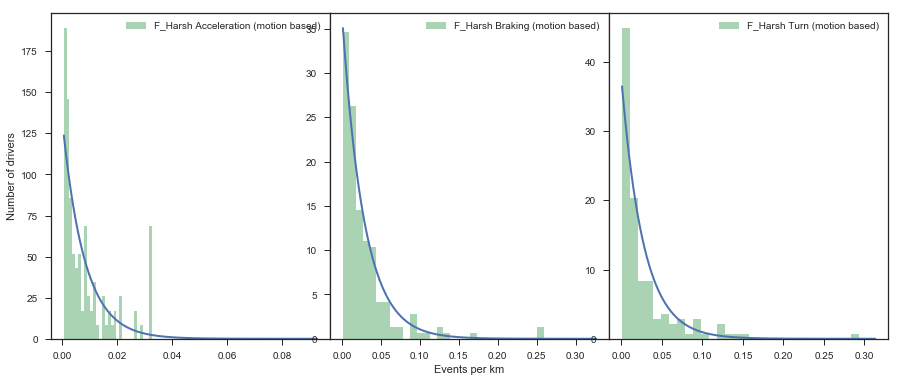

In [44]:
import matplotlib.pyplot as plt
import scipy.stats as st

DIST = st.expon

def create_pdf(dist, params, size=10000):

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99999, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99999, loc=loc, scale=scale)
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

## fit exponential distribution
fig, axs = plt.subplots(1,3, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()
i=0
for col in cleanFeatures:
    print(col)
    feature = cleanFeatures[col]
    x = feature.values[feature.values > 0] # only fit positive values to keep the distribution tighter
   
    params = DIST.fit(x)

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]
   
    #Plot
    pdfForPlot = create_pdf(DIST,params)
    pdfForPlot.plot(lw=2, label='PDF',ax=axs[i])
    
    #Plot
    feature[feature.values >0].plot(kind='hist', bins=30, density=True, alpha=0.5, label=feature.name, legend=True,ax=axs[i])
    axs[i].set_ylabel('')
    axs[i].set_xlabel('')
    ## Calculate SSE
    yhist, xhist = np.histogram(x, bins=60, density=True)
    xhist = (xhist + np.roll(xhist, -1))[:-1] / 2.0
    histPdf = DIST.pdf(xhist, loc=loc, scale=scale, *arg)
    sse = np.sum(np.power(yhist - histPdf, 2.0))
    print("sse:",sse)
    i+=1
axs[1].set_xlabel('Events per km')
axs[0].set_ylabel('Number of drivers')

    

#### Create a single metric
The commulative metric is the sum (or weighted sum) of CDFs per event type

In [31]:
def calculate_joint_score(perFeatureScores):
    driverScores = perFeatureScores
    featureCols = [col for col in driverScores if col.startswith('F_')]
    driverScores['metric'] = (driverScores[featureCols].sum(axis = 1) / 3.0)
    driverScores = driverScores.sort_values('metric')
    driverScores['rank'] = driverScores.metric.rank(method="min")/len(perFeatureScores)*1.0
    return driverScores

driverScores = calculate_joint_score(perFeatureScores)

Since the entire population won't be available on test time, we fit a simple linear model to find the relation between the metric (weighted sum of CDFs) and the rank (the position in the population). We will use the metric value at test time, and this model to estimate the driver's hypothetical rank in this population. Since we are doing in-population analysis, and this is a very simple model, there's no need for train/test split.

In [32]:
from sklearn.linear_model import LinearRegression

def get_linear_model(perFeatureScores):
    driverScores = calculate_joint_score(perFeatureScores)
    reg = LinearRegression()
    x = driverScores['metric'].values.reshape(-1, 1)
    y = driverScores['rank'].values.reshape(-1, 1)
    reg.fit(x,y)
    return reg
    

def get_rank(regModel,metric):
    rank = regModel.predict(metric)
    rank = np.asscalar(np.where(rank > 1,1,rank))
    rank = np.asscalar(np.where(rank < 0,0,rank))
    return rank
    
regModel = get_linear_model(perFeatureScores)
sampleRank = get_rank(regModel,0.5)
sampleRank

0.6797053034348477

In [33]:
## Top 10 safest drivers?
driverScores.head(10)

,F_Harsh Acceleration (motion based)_CDF,F_Harsh Braking (motion based)_CDF,F_Harsh Turn (motion based)_CDF,metric,rank
68,0.0000,0.0000,0.0000,0.0000,0.0053
47,0.0000,0.0000,0.0000,0.0000,0.0053
25,0.0000,0.0000,0.0000,0.0000,0.0053
51,0.0000,0.0000,0.0000,0.0000,0.0053
27,0.0000,0.0000,0.0000,0.0000,0.0053
29,0.0000,0.0000,0.0000,0.0000,0.0053
131,0.0000,0.0000,0.0000,0.0000,0.0053
32,0.0000,0.0000,0.0000,0.0000,0.0053
177,0.0000,0.0000,0.0000,0.0000,0.0053
180,0.0000,0.0000,0.0000,0.0000,0.0053


In [34]:
## top 10 most risky drivers?
driverScores.tail(10)

,F_Harsh Acceleration (motion based)_CDF,F_Harsh Braking (motion based)_CDF,F_Harsh Turn (motion based)_CDF,metric,rank
37,0.4929,0.9882,0.9903,0.8238,0.9524
133,0.9050,0.8965,0.6992,0.8335,0.9577
15,0.9817,0.5857,0.9883,0.8519,0.9630
171,0.6117,0.9999,0.9707,0.8608,0.9683
145,0.8259,0.8535,0.9147,0.8647,0.9735
78,0.9817,0.7335,0.9583,0.8912,0.9788
170,0.9630,0.8161,0.9223,0.9004,0.9841
113,0.9817,0.9557,0.8768,0.9381,0.9894
82,0.9817,0.8549,0.9913,0.9426,0.9947
163,0.9817,0.8866,0.9885,0.9523,1.0000


## Distributions of CDFs, rank and metric values

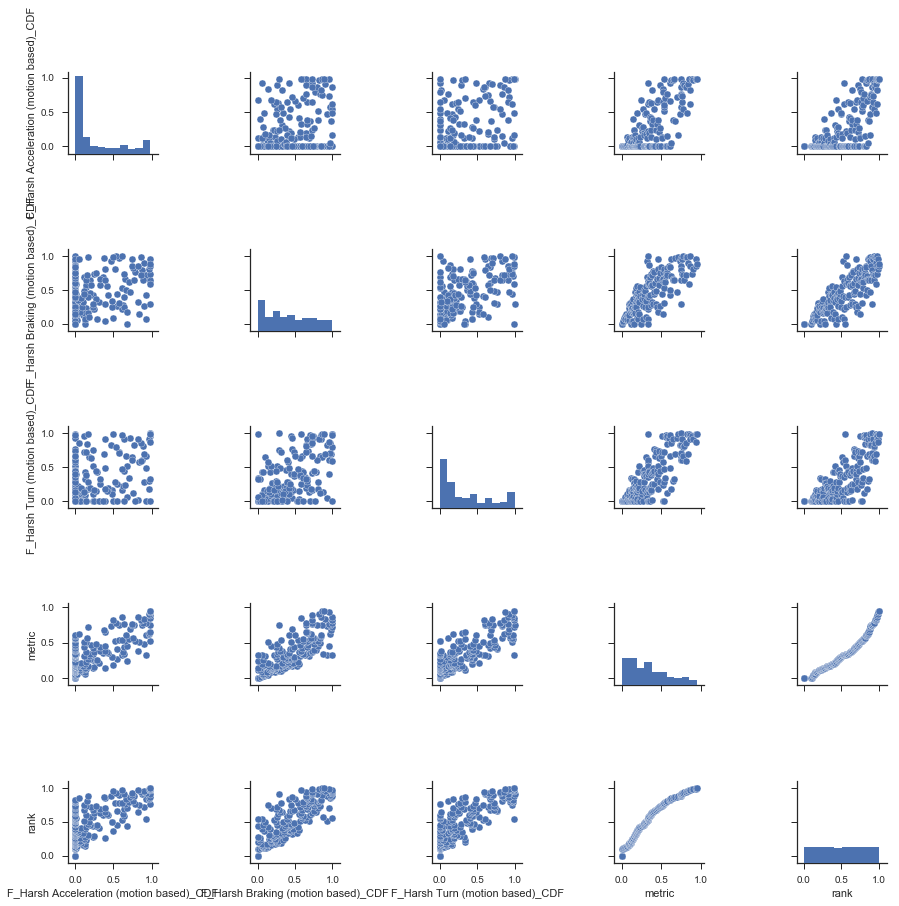

In [35]:
import seaborn as sns
sns.set(style="ticks")
sns.pairplot(driverScores)

### Estimating safety for an arbitrary subscriber
The following process estimates the score of a new driver:
1. Calculate features - number of events per km
2. Calculate CDFs by estimating the CDF per feature value using the fitted functions during 'training'. We use the function's parameters to estimate the CDF per new value.
3. Calculate the weighted sum metric. The value of this metric corresponds to the point in the population this new driver resides in.
4. Calculate a rank within a population

In [36]:
safeDriver = [{'F_Harsh Acceleration (motion based)':0,
                       'F_Harsh Braking (motion based)':0.001,
                       'F_Harsh Turn (motion based)':0}]

riskyDriver = [{'F_Harsh Acceleration (motion based)':0.2,
                       'F_Harsh Braking (motion based)':0.16,
                       'F_Harsh Turn (motion based)':0.28}]

safeDriverDf = pd.DataFrame(safeDriver)
riskyDriverDf = pd.DataFrame(riskyDriver)

print('****** Estimated safety scores ******')
def get_score_one_driver(driverDf,fittedParams,minPerFeature,maxPerFeature):

    normalized = (driverDf - minPerFeature) / (maxPerFeature - minPerFeature)
    scoreDF = pd.DataFrame()
    for col in normalized:
        scoreDF[col] = calculate_score_for_series(normalized[col],fittedParams)
    scoreDF = calculate_joint_score(scoreDF)
    return scoreDF


safeDriverWithMetric = get_score_one_driver(safeDriverDf, fittedParams,minPerFeature,maxPerFeature)
riskyDriverWithMetric = get_score_one_driver(riskyDriverDf, fittedParams,minPerFeature,maxPerFeature)

safeDriverMetric = safeDriverWithMetric['metric'].values[0]
riskyDriverMetric = riskyDriverWithMetric['metric'].values[0]


print('------')
print("Rank for safe driver = {}".format(get_rank(regModel,safeDriverMetric)))
print("Metric for safe driver = {}".format(safeDriverMetric))
print('------')
print("Rank for risky driver = {}".format(get_rank(regModel,riskyDriverMetric)))
print("Metric for risky driver = {}".format(riskyDriverMetric))

****** Estimated safety scores ******
Calculating scores for feature: F_Harsh Acceleration (motion based)
Calculating scores for feature: F_Harsh Braking (motion based)
Calculating scores for feature: F_Harsh Turn (motion based)
Calculating scores for feature: F_Harsh Acceleration (motion based)
Calculating scores for feature: F_Harsh Braking (motion based)
Calculating scores for feature: F_Harsh Turn (motion based)
------
Rank for safe driver = 0.15034644758327007
Metric for safe driver = 0.029705358241911162
------
Rank for risky driver = 1.0
Metric for risky driver = 0.9999999998856292


There are two alternatives here for results: the metric (weighted sum), which gives a score with regards to the amount of events of each type, and the rank, which shows on which percentile of the population the driver is. Depending on the use case, one can decide on the right metric.
Since the relation between these two metrics is not 100% linear, we get different results than the training set. In this case we get a rank of 0.15 for a driver with almost 0 events.

# Deployment on a Spark cluster
The PySpark code is very similar to the pandas code. It performs the feature calculation and normalization on a spark cluster, where each car/driver's data is computed separately. Then it aggregates the data into one node and performs the population statistics on this node. This process is run for each segment in the population, where segments are groups of drivers with similar attributes (e.g. same type of vehicle, same country, same device installed, same device firmware/software).

For the PySpark version of this analysis, open [this notebook](Driver safety estimation - pyspark.ipynb)